# Assignment 3 - SMAI - DoubleMNIST and PermutedMnist

In [1]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files


In [2]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import glob
import cv2
import scipy
import scipy.io
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import wandb
import yaml

from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.utils.data import random_split

import torchvision
from torchvision import transforms

In [4]:
from src_torch import *
from src_torch.classifiers import *

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vanshg. Use `wandb login --relogin` to force relogin


True

## (5.1) Multi-digit Recognition on Multi-MNIST Dataset

### (5.1.0) Data Loading, Preprocessing and Visualization

In [28]:
DOUBLE_MNIST_FOLDER = os.path.join(DATA_FOLDER, "DOUBLE_MNIST")

train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

forbidden_labels = [11 * i for i in range(10)]

# Saving path of all images in train set
for img_folder in glob.glob(os.path.join(DOUBLE_MNIST_FOLDER, "train/*")):
    label = int(os.path.basename(img_folder))
    if label in forbidden_labels:
        continue
    for img_file in glob.glob(os.path.join(img_folder, "*")):
        image = torchvision.io.read_image(img_file)
        train_labels.append(label)
        train_images.append(image)

# Saving path of all images in val set
for img_folder in glob.glob(os.path.join(DOUBLE_MNIST_FOLDER, "val/*")):
    label = int(os.path.basename(img_folder))
    if label in forbidden_labels:
        continue
    for img_file in glob.glob(os.path.join(img_folder, "*")):
        image = torchvision.io.read_image(img_file)
        val_labels.append(label)
        val_images.append(image)

# Saving path of all images in test set
for img_folder in glob.glob(os.path.join(DOUBLE_MNIST_FOLDER, "test/*")):
    label = int(os.path.basename(img_folder))
    if label in forbidden_labels:
        continue
    for img_file in glob.glob(os.path.join(img_folder, "*")):
        image = torchvision.io.read_image(img_file)
        test_labels.append(label)
        test_images.append(image)

train_images = torch.stack(train_images, dim=0)
val_images = torch.stack(val_images, dim=0)
test_images = torch.stack(test_images, dim=0)

print(f"Shape of Training data: {train_images.shape}")
print(f"Shape of Validation data: {val_images.shape}")
print(f"Shape of Testing Data: {test_images.shape}")

Shape of Training data: torch.Size([58000, 1, 64, 64])
Shape of Validation data: torch.Size([14000, 1, 64, 64])
Shape of Testing Data: torch.Size([18000, 1, 64, 64])


In [29]:
# Pre-processing and creating a Pytorch Tensor Dataset
def convert_to_onehot(label):
    one_hot_label = torch.zeros(10)
    first_digit = label % 10
    one_hot_label[first_digit] = 1.0
    label = label // 10
    if label:
        second_digit = label % 10
        one_hot_label[second_digit] = 1.0
    else:
        one_hot_label[0] = 1.0
    
    return one_hot_label

def onehot_to_number(onehot_label):
    number = 0
    for i, num in enumerate(onehot_label[1:]):
        if num:
            number = number * 10 + num *  (i + 1)
    
    if onehot_label[0]:
        number = number * 10
    
    return int(number)

train_dataset = DoubleMNIST(train_images, train_labels, target_transform=convert_to_onehot)
val_dataset = DoubleMNIST(val_images, val_labels, target_transform=convert_to_onehot)
test_dataset = DoubleMNIST(test_images, test_labels, target_transform=convert_to_onehot)

In [30]:
y_values = []
for x, y in train_dataset:
    y_values.append(onehot_to_number(y))

y_values = torch.tensor(y_values)
train_classes = torch.unique(y_values)
print(train_classes)

tensor([10, 12, 13, 14, 15, 16, 18, 19, 20, 23, 24, 26, 27, 28, 29, 30, 34, 35,
        36, 37, 38, 40, 45, 47, 48, 49, 50, 56, 57, 58, 59, 60, 67, 69, 70, 78,
        79, 80, 89, 90])


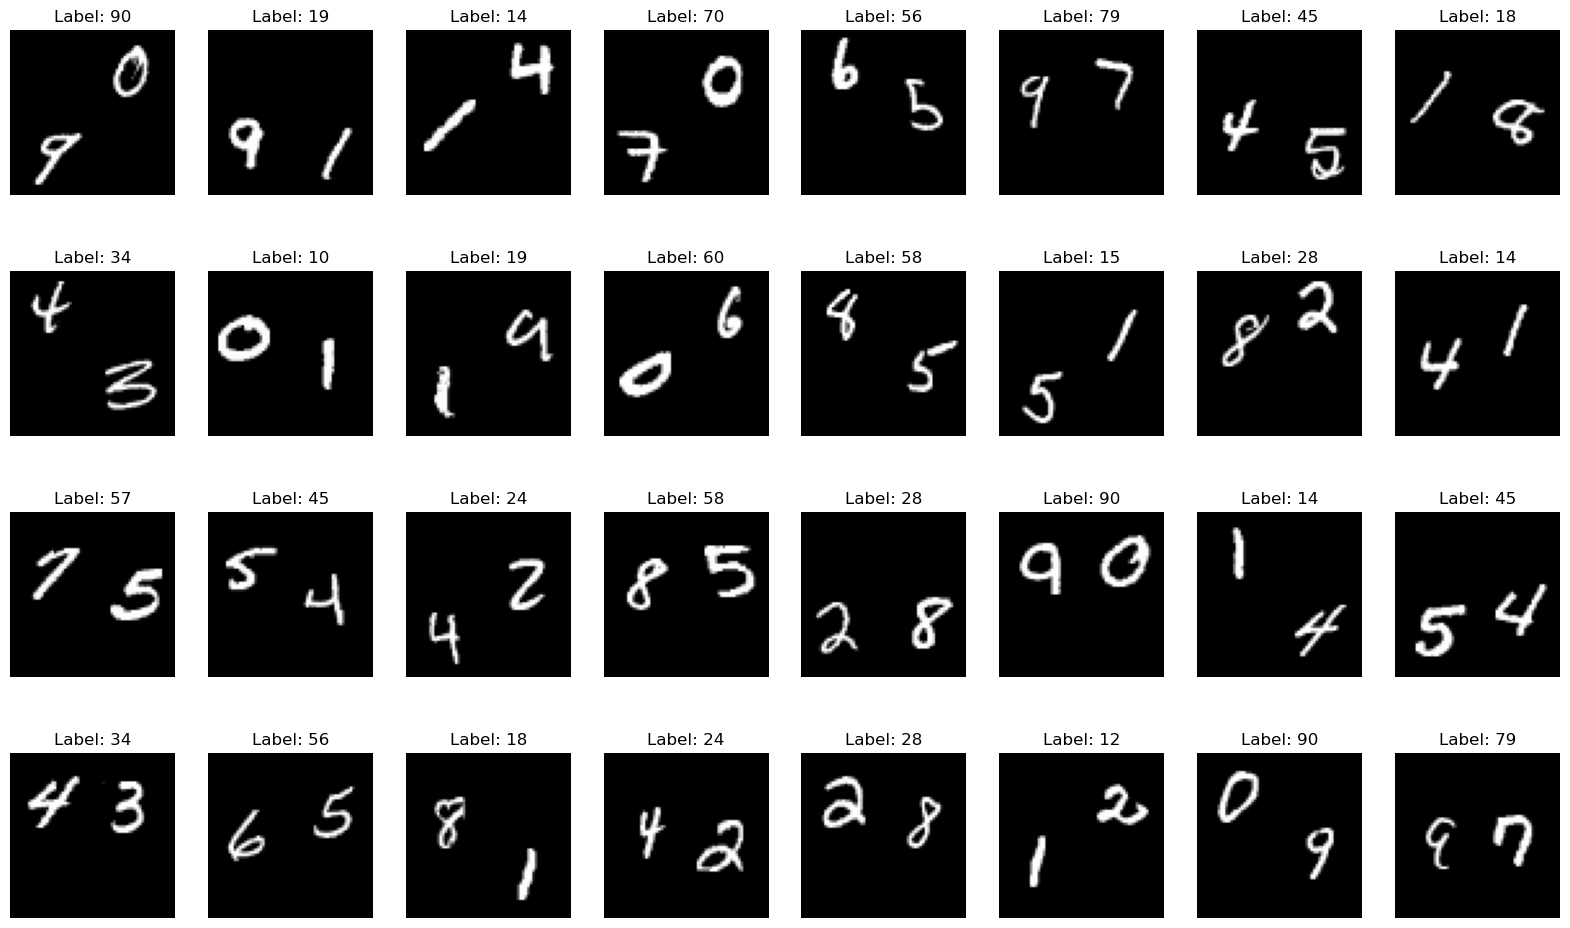

In [10]:
# Visualizing Images
num_display = 32
indices = np.random.choice(np.arange(len(train_dataset)), num_display)

plots_per_row = 8
num_rows = num_display // plots_per_row
if num_display % plots_per_row:
    num_rows += 1

fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(20, 12))
axs = axs.flatten()

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]
    label = onehot_to_number(label)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
    axs[i].imshow(image.squeeze(), cmap='gray')

plt.show()

### (5.1.1) MLP on DoubleMnist

In [ ]:
torch.manual_seed(42)
mlp_model = SimpleMLP(input_dim=64*64, hidden_dims=[1000], num_classes=10, last_activation='sigmoid', flatten_first=True)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

train_config = {
    "device": device,
    "print_every": 250,
    "argmax": False
}

_ = train(mlp_model, criterion, optimizer, train_dataset, val_dataset, **train_config)

In [ ]:
eval_config = {
    "device": device,
    "argmax": False
}

test_acc, test_loss = evaluate(mlp_model, test_dataset, **eval_config)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

#### (5.1.1.2) - Hyper-parameter Tuning with Wandb

In [10]:
def get_model(config):
    input_dim = config.pop("input_dim")
    num_classes = config.pop("num_classes")

    # Number of layers
    num_layers = config.pop("num_layers", 1)
    hidden_dims = []

    for i in range(1, num_layers + 1):
        dim = config.pop(f"hidden_dims{i}")
        hidden_dims.append(dim)
    
    model = SimpleMLP(input_dim, hidden_dims, num_classes, **config)
    return model

def get_criterion(crit_name):
    if crit_name == "CE":
        return nn.CrossEntropyLoss()
    elif crit_name == "BCE":
        return nn.BCELoss()

def get_optimizer(model, config):
    lr = config["learning_rate"]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

def trigger_training(config, train_dataset, val_dataset):
    torch.manual_seed(42)
    # getting the model, criterion and optimizer
    model = get_model(config["model"])
    print(model, flush=True)
    criterion = get_criterion(config["criterion"])
    optimizer = get_optimizer(model, config["optimizer"])

    # training config
    train_config = config["training"]
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    
    train(
        model, criterion, optimizer, train_dataset, val_dataset, device=device, **train_config)
    
    return model

In [32]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "BCE",
        "model": {
            "input_dim":64*64,
            "num_layers": 1,
            "hidden_dims1": 1024,
            "num_classes": 10,
            "last_activation": "sigmoid",
            "flatten_first": True
        },
        "optimizer": {
            "learning_rate": 0.01,
        },
        "training": {
            "batch_size": 128,
            "epochs": 10,
            "print_every": 100,
            # "log_wandb": True,
            "verbose": True,
            "print_every": 250,
            "argmax": False
        }
    }
}

model = trigger_training(config["parameters"], train_dataset, val_dataset)

Model Type: MLP
SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
    (3): Sigmoid()
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 454
Iteration: 1/4540 | loss = 0.6962
Iteration: 250/4540 | loss = 0.3965
Epoch: 1 | Train Accuracy: 11.938 | Val Accuracy: 2.907|  Train loss: 15.1309 | Val loss: 17.5471

Iteration: 500/4540 | loss = 0.3559
Iteration: 750/4540 | loss = 0.3330
Epoch: 2 | Train Accuracy: 19.728 | Val Accuracy: 5.964|  Train loss: 12.5688 | Val loss: 16.5821

Iteration: 1000/4540 | loss = 0.3070
Iteration: 1250/4540 | loss = 0.3168
Epoch: 3 | Train Accuracy: 23.967 | Val Accuracy: 6.229|  Train loss: 11.6688 | Val loss: 16.8943

Iteration: 1500/4540 | loss = 0.2961
Iteration: 1750/4540 | loss = 0.2949
Epoch: 4 | Train Accuracy: 27.338 | Val Accuracy: 6.293|  Train loss: 11.1791 | Val loss: 16.7679

Iteration: 2000/4540 | loss = 0.

In [33]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))

    # setting the wandb run name for the current config
    model_type = get_model_type(config["model"])
    if model_type == "CNN":
        run_name = make_wandb_run_name_cnn(config)
    elif model_type == "MLP":
        run_name = make_wandb_run_name_mlp(config)
    else:
        return
    print(f"Run Name: {run_name}")
    run.name = run_name

    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [34]:
f = open(os.path.join(YAML_FOLDER, "task-5.1.1/multi-mnist-single-layer.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task5', 'name': 'multi-mnist-single-layer', 'parameters': {'criterion': {'value': 'BCE'}, 'model.input_dim': {'value': 4096}, 'model.num_layers': {'value': 1}, 'model.hidden_dims1': {'values': [2048, 1024, 512]}, 'model.num_classes': {'value': 10}, 'model.last_activation': {'value': 'sigmoid'}, 'model.flatten_first': {'value': True}, 'optimizer.learning_rate': {'values': [0.01, 0.001, 0.0005]}, 'training.batch_size': {'values': [64, 128, 256]}, 'training.epochs': {'value': 10}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 250}, 'training.argmax': {'value': False}}}


In [35]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task5")

Create sweep with ID: y1ci8mik
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task5/sweeps/y1ci8mik


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

wandb: Agent Starting Run: kp425k2m with config:
wandb: 	criterion: BCE
wandb: 	model.flatten_first: True
wandb: 	model.hidden_dims1: 2048
wandb: 	model.input_dim: 4096
wandb: 	model.last_activation: sigmoid
wandb: 	model.num_classes: 10
wandb: 	model.num_layers: 1
wandb: 	optimizer.learning_rate: 0.01
wandb: 	training.argmax: False
wandb: 	training.batch_size: 64
wandb: 	training.epochs: 10
wandb: 	training.log_wandb: True
wandb: 	training.print_every: 250
wandb: 	training.verbose: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: H2048-lr0.01-batch64
Model Type: MLP
SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=10, bias=True)
    (3): Sigmoid()
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 907
Iteration: 1/9070 | loss = 0.6934
Iteration: 250/9070 | loss = 0.4200
Iteration: 500/9070 | loss = 0.4453
Iteration: 750/9070 | loss = 0.3919
Epoch: 1 | Train Accuracy: 6.478 | Val Accuracy: 1.779|  Train loss: 15.7500 | Val loss: 17.3993

Iteration: 1000/9070 | loss = 0.3797
Iteration: 1250/9070 | loss = 0.3724
Iteration: 1500/9070 | loss = 0.3818
Iteration: 1750/9070 | loss = 0.3278
Epoch: 2 | Train Accuracy: 10.984 | Val Accuracy: 2.421|  Train loss: 14.3202 | Val loss: 17.0793

Iteration: 2000/9070 | loss = 0.3259
Iteration: 2250/9070 | loss = 0.3541
Iteration: 2500/9070 | loss = 0.3276
Epoch: 3 | Train Accuracy: 15.710 | Val Accuracy: 2.936|  Train loss: 13.6540 | Val loss:

best_epoch,▁
best_val_acc,▁
best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▅▆▆▇███
train_loss,█▆▅▃▃▂▂▁▁▁
val_acc,▁▄▆▆▂▅▄▄█▃
val_loss,▄▁▅▆▄▂▅▇▆█
best_epoch,9
best_val_acc,0.03314
best_val_loss,17.60929


wandb: Agent Starting Run: axiaf68e with config:
wandb: 	criterion: BCE
wandb: 	model.flatten_first: True
wandb: 	model.hidden_dims1: 2048
wandb: 	model.input_dim: 4096
wandb: 	model.last_activation: sigmoid
wandb: 	model.num_classes: 10
wandb: 	model.num_layers: 1
wandb: 	optimizer.learning_rate: 0.01
wandb: 	training.argmax: False
wandb: 	training.batch_size: 128
wandb: 	training.epochs: 10
wandb: 	training.log_wandb: True
wandb: 	training.print_every: 250
wandb: 	training.verbose: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Ctrl + C detected. Stopping sweep.


Run Name: H2048-lr0.01-batch128
Model Type: MLP
SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=10, bias=True)
    (3): Sigmoid()
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 454
Iteration: 1/4540 | loss = 0.6937
Iteration: 250/4540 | loss = 0.3939


### (5.1.2) CNN on DoubleMnist

In [ ]:
torch.manual_seed(42)
cnn_model = SimpleCNN(input_dim=64, num_channels=10, kernel_size=5, num_classes=10, last_activation='sigmoid')
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

train_config = {
    "device": device,
    # "calc_accuracy": False,
    "print_every": 250,
    "argmax": False
}

_ = train(cnn_model, criterion, optimizer, train_dataset, val_dataset, **train_config)

In [ ]:
eval_config = {
    "device": device,
    "argmax": False
}

test_acc, test_loss = evaluate(cnn_model, test_dataset, **eval_config)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

## (5.2) - Permuted MNIST

### (5.2.0) Data Loading, PreProcessing and Visualizing

In [7]:
PERMUTED_MNIST_FILE = os.path.join(DATA_FOLDER, "permuted_mnist.npz")

data = np.load(PERMUTED_MNIST_FILE)

train_images = torch.tensor(data['train_images'])/255.0
train_images = train_images.unsqueeze(1)
train_labels = torch.tensor(data['train_labels'])
test_images = torch.tensor(data['test_images'])/255.0
test_images = test_images.unsqueeze(1)
test_labels = torch.tensor(data['test_labels'])

complete_train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


#### Splitting into Train/Val Data

In [8]:
val_ratio = 0.3
val_size = int(val_ratio * len(complete_train_dataset))
train_size = len(complete_train_dataset) - val_size

train_dataset, val_dataset = random_split(complete_train_dataset, [train_size, val_size])

print(f"Length of Training Data: {len(train_dataset)}")
print(f"Length of Validation Data: {len(val_dataset)}")
print(f"Length of Testing Data: {len(test_dataset)}")

Length of Training Data: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


### (5.2.1) - MLP on Permuted MNIST

In [9]:
model_config = {
    "input_dim": 28*28,
    "hidden_dims": [],
    "num_classes": 10,
    "flatten_first": True
}

mlp_model = SimpleMLP(**model_config)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

print(mlp_model)

train_config = {
    "device": device,
    "print_every": 100
}

_ = train(mlp_model, criterion, optimizer, train_dataset, val_dataset, **train_config)

SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 420
Iteration: 1/4200 | loss = 2.3044
Iteration: 100/4200 | loss = 0.4677
Iteration: 200/4200 | loss = 0.2488
Iteration: 300/4200 | loss = 0.1896
Iteration: 400/4200 | loss = 0.3136
Epoch: 1 | Train Accuracy: 92.107 | Val Accuracy: 91.600|  Train loss: 0.2865 | Val loss: 0.3030

Iteration: 500/4200 | loss = 0.2994
Iteration: 600/4200 | loss = 0.2329
Iteration: 700/4200 | loss = 0.3318
Iteration: 800/4200 | loss = 0.1789
Epoch: 2 | Train Accuracy: 91.771 | Val Accuracy: 90.844|  Train loss: 0.2837 | Val loss: 0.3090

Iteration: 900/4200 | loss = 0.2744
Iteration: 1000/4200 | loss = 0.3343
Iteration: 1100/4200 | loss = 0.2791
Iteration: 1200/4200 | loss = 0.2781
Epoch: 3 | Train Accuracy: 92.374 | Val Accuracy: 91.461|  Train loss: 0.2692 | Val loss: 0.3075

Iteration: 1300/4200 | loss = 0.1850
Iteration: 1400/4200 | loss = 0.34

In [30]:
# Testing performance on Test Dataset
test_acc, test_loss = evaluate(mlp_model, test_dataset, device=device)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 91.8700 | Test Loss: 0.3127


#### (5.2.1.2) Hyperparameter Tuning with Wandb

In [ ]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "input_dim":28*28,
            "num_layers": 1,
            "hidden_dims1": 2048,
            "num_classes": 10,
            "flatten_first": True
        },
        "optimizer": {
            "learning_rate": 0.01,
        },
        "training": {
            "batch_size": 128,
            "epochs": 10,
            "print_every": 100,
            # "log_wandb": True,
            "verbose": True,
            "print_every": 250,
        }
    }
}

model = trigger_training(config["parameters"], train_dataset, val_dataset)

In [17]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))

    # setting the wandb run name for the current config
    model_type = get_model_type(config["model"])
    if model_type == "CNN":
        run_name = make_wandb_run_name_cnn(config)
    elif model_type == "MLP":
        run_name = make_wandb_run_name_mlp(config)
    else:
        return
    print(f"Run Name: {run_name}")
    run.name = run_name

    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [25]:
f = open(os.path.join(YAML_FOLDER, "task-5.1.2/permuted-mnist-single-layer.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task5', 'name': 'permuted-mnist-single-layer', 'parameters': {'criterion': {'value': 'CE'}, 'model.input_dim': {'value': 784}, 'model.num_layers': {'value': 1}, 'model.hidden_dims1': {'values': [1024, 512, 256]}, 'model.num_classes': {'value': 10}, 'model.flatten_first': {'value': True}, 'optimizer.learning_rate': {'values': [0.01, 0.001, 0.0005]}, 'training.batch_size': {'values': [64, 128, 256]}, 'training.epochs': {'value': 10}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 250}}}


In [26]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task5")

Create sweep with ID: kr42ue6x
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task5/sweeps/kr42ue6x


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

wandb: Agent Starting Run: rx7h1i0g with config:
wandb: 	criterion: CE
wandb: 	model.flatten_first: True
wandb: 	model.hidden_dims1: 1024
wandb: 	model.input_dim: 784
wandb: 	model.num_classes: 10
wandb: 	model.num_layers: 1
wandb: 	optimizer.learning_rate: 0.01
wandb: 	training.batch_size: 64
wandb: 	training.epochs: 10
wandb: 	training.log_wandb: True
wandb: 	training.print_every: 250
wandb: 	training.verbose: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: H1024-lr0.01-batch64
Model Type: MLP
SimpleMLP(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)

Model is on device: cuda

Number of Iterations Per Epoch: 657
Iteration: 1/6570 | loss = 2.2978
Iteration: 250/6570 | loss = 0.2229
Iteration: 500/6570 | loss = 0.0947
Epoch: 1 | Train Accuracy: 95.890 | Val Accuracy: 94.844|  Train loss: 0.1382 | Val loss: 0.1929

Iteration: 750/6570 | loss = 0.2264
Iteration: 1000/6570 | loss = 0.0503
Iteration: 1250/6570 | loss = 0.0982
Epoch: 2 | Train Accuracy: 96.243 | Val Accuracy: 94.822|  Train loss: 0.1389 | Val loss: 0.2290

Iteration: 1500/6570 | loss = 0.1171
Iteration: 1750/6570 | loss = 0.1380
Epoch: 3 | Train Accuracy: 98.136 | Val Accuracy: 96.378|  Train loss: 0.0665 | Val loss: 0.1592

Iteration: 2000/6570 | loss = 0.1707
Iteration: 2250/6570 | loss = 0.0130
Iteration: 2500/6570 | loss = 0.0051
Epoch: 4 | T

wandb: Ctrl + C detected. Stopping sweep.


best_epoch,▁
best_val_acc,▁
best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▇▆▇▅███▇
train_loss,██▃▃▂▄▁▁▁▄
val_acc,▁▁█▆▇▅███▆
val_loss,▂▄▁▃▃▄▃▄▄█
best_epoch,7
best_val_acc,0.964
best_val_loss,0.20768


### (5.2.2) CNN on Permuted MNIST

In [10]:
cnn_model = SimpleCNN(kernel_size=5, num_channels=128, stride=1, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

train_config = {
    "device": device,
    "print_every": 100
}

_ = train(cnn_model, criterion, optimizer, train_dataset, val_dataset, **train_config)


Model is on device: cuda

Number of Iterations Per Epoch: 420


Iteration: 1/4200 | loss = 2.2936
Iteration: 100/4200 | loss = 0.5255
Iteration: 200/4200 | loss = 0.3674
Iteration: 300/4200 | loss = 0.2020
Iteration: 400/4200 | loss = 0.3121
Epoch: 1 | Train Accuracy: 93.924 | Val Accuracy: 92.917|  Train loss: 0.1974 | Val loss: 0.2287

Iteration: 500/4200 | loss = 0.2596
Iteration: 600/4200 | loss = 0.1675
Iteration: 700/4200 | loss = 0.3777
Iteration: 800/4200 | loss = 0.4231
Epoch: 2 | Train Accuracy: 94.250 | Val Accuracy: 92.867|  Train loss: 0.1790 | Val loss: 0.2258

Iteration: 900/4200 | loss = 0.2809
Iteration: 1000/4200 | loss = 0.1896
Iteration: 1100/4200 | loss = 0.2677
Iteration: 1200/4200 | loss = 0.2256
Epoch: 3 | Train Accuracy: 95.355 | Val Accuracy: 93.706|  Train loss: 0.1491 | Val loss: 0.2142

Iteration: 1300/4200 | loss = 0.3346
Iteration: 1400/4200 | loss = 0.3543
Iteration: 1500/4200 | loss = 0.1842
Iteration: 1600/4200 | loss = 0.1868
Epoch: 4 | Train Accuracy: 95.100 | Val Accuracy: 93.489|  Train loss: 0.1730 | Val loss:

In [14]:
test_acc, test_loss = evaluate(cnn_model, test_dataset, device=device)
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 94.0400 | Test Loss: 0.2229


#### (5.2.2.2) Hyperparameter Tuning with Wandb

In [21]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "input_dim": 28,
            "conv_layers": 2,
            "num_channels": 128,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 0.01,
        },
        "training": {
            "batch_size": 100,
            "epochs": 10,
            "print_every": 100,
            # "log_wandb": True,
            "verbose": True
        }
    }
}

model = trigger_training(config["parameters"], train_dataset, val_dataset)

Model Type: CNN
SimpleCNN(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)

Model is on device: cuda

Number of Iterations Per Epoch: 420


Iteration: 1/4200 | loss = 2.3129
Iteration: 100/4200 | loss = 0.4289
Iteration: 200/4200 | loss = 0.1083
Iteration: 300/4200 | loss = 0.3153
Iteration: 400/4200 | loss = 0.0704
Epoch: 1 | Train Accuracy: 94.367 | Val Accuracy: 93.294|  Train loss: 0.1789 | Val loss: 0.2143

Iteration: 500/4200 | loss = 0.3283
Iteration: 600/4200 | loss = 0.2205
Iteration: 700/4200 | loss = 0.1709
Iteration: 800/4200 | loss = 0.2059
Epoch: 2 | Train Accuracy: 95.750 | Val Accuracy: 93.978|  Train loss: 0.1357 | Val loss: 0.2013

Iteration: 900/4200 | loss = 0.0430
Iteration: 1000/4200 | loss = 0.2748
Iteration: 1100/4200 | loss = 0.1318
Iteration: 1200/4200 | loss = 0.3149
Epoch: 3 | Train Accuracy: 93.698 | Val Accuracy: 91.806|  Train loss: 0.1887 | Val loss: 0.2596

Iteration: 1300/4200 | loss = 0.1118
Iteration: 1400/4200 | loss = 0.1045
Iteration: 1500/4200 | loss = 0.2480
Iteration: 1600/4200 | loss = 0.2119
Epoch: 4 | Train Accuracy: 96.067 | Val Accuracy: 93.772|  Train loss: 0.1245 | Val loss:

In [23]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))

    # setting the wandb run name for the current config
    model_type = get_model_type(config["model"])
    if model_type == "CNN":
        run_name = make_wandb_run_name_cnn(config)
    elif model_type == "MLP":
        run_name = make_wandb_run_name_mlp(config)
    else:
        return
    print(f"Run Name: {run_name}")
    run.name = run_name

    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [24]:
f = open(os.path.join(YAML_FOLDER, "task-5.1.2/permuted-mnist-two-conv-layers.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task5', 'name': 'permuted-mnist-two-conv-layers', 'parameters': {'criterion': {'value': 'CE'}, 'model.conv_layers': {'value': 2}, 'model.num_channels': {'values': [32, 64, 128]}, 'model.kernel_size': {'values': [3, 5]}, 'model.stride': {'values': [1, 3]}, 'model.dropout': {'values': [0, 0.1]}, 'model.num_classes': {'value': 10}, 'optimizer.learning_rate': {'values': [0.01, 0.001]}, 'training.batch_size': {'values': [128]}, 'training.epochs': {'value': 20}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 100}}}


In [ ]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task4")

In [13]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

NameError: name 'sweep_id' is not defined

## (5.3) Analysis